In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import sklearn.metrics
from pandas import Series, DataFrame

C:\Users\hyunj\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 1000)

# Modeling with 1/3 data

In [4]:
modelingdf_33=pd.read_csv('modelingdf_33.csv')

In [5]:
modelingdf_33.isnull().sum()

gender                     0
region                     0
highest_education          0
imd_band                 998
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
click_mean                 0
submit_early            4398
preview                 4515
click_std                  0
dtype: int64

In [6]:
modelingdf_33['imd_band'] = modelingdf_33['imd_band'].fillna('NaN')
modelingdf_33['submit_early'] = modelingdf_33['submit_early'].fillna(-101)
modelingdf_33['preview'] = modelingdf_33['preview'].fillna(0)

In [7]:
# Extract data except withdrawn
modelingdf_33 = modelingdf_33[modelingdf_33['final_result']!='Withdrawn']

In [8]:
# collect categorical variables
cats=[]
for col in modelingdf_33.columns.values:
    if modelingdf_33[col].dtype == 'object':
        cats.append(col)
cats

['gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability',
 'final_result']

In [9]:
# Dummification
def dummify_cols(df,cols):
    return df.join([pd.get_dummies(df[col], prefix=col) for col in cols])

In [10]:
modelingdf_33_dummies = dummify_cols(modelingdf_33,cats[:6])
modelingdf_33_dummies.head()

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,click_mean,submit_early,preview,click_std,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,imd_band_0-10%,imd_band_10-20%,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,imd_band_NaN,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,7.981481,1.0,1.0,9.007075,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
1,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,8.407407,-0.5,7.0,3.538654,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,11.759259,2.5,5.0,2.743366,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,5.666667,-14.0,8.0,3.197831,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,12.055556,-5.0,9.0,2.860344,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0


In [11]:
modelingdf_33_dummies.columns.values

array(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'final_result', 'click_mean', 'submit_early', 'preview',
       'click_std', 'gender_F', 'gender_M', 'region_East Anglian Region',
       'region_East Midlands Region', 'region_Ireland',
       'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'imd_band_0-10%',
       'imd_band_10-20%', 'imd_band_20-30%', 'imd_band_30-40%',
       'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%

In [12]:
feature_cols = ['num_of_prev_attempts', 'studied_credits','click_mean', 'submit_early', 'preview',
       'click_std', 'gender_F', 'gender_M', 'region_East Anglian Region',
       'region_East Midlands Region', 'region_Ireland',
       'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'imd_band_0-10%',
       'imd_band_10-20%', 'imd_band_20-30%', 'imd_band_30-40%',
       'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%',
       'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%',
       'imd_band_NaN', 'age_band_0-35', 'age_band_35-55', 'age_band_55<=',
       'disability_N', 'disability_Y']
X_33 = modelingdf_33_dummies[feature_cols]
Y_33 = modelingdf_33_dummies['final_result']
X_33_train, X_33_test, Y_33_train, Y_33_test = train_test_split(X_33, Y_33, test_size = 0.2)

In [13]:
dt_33 = tree.DecisionTreeClassifier() # 디시전트리 모델을 만들어 주고 (parameter는 훨씬 많아요!, 자세한건 shift+tab)
dt_33.fit(X_33_train[feature_cols], Y_33_train) # 예측하고
predictions_dt_33 = dt_33.predict(X_33_test[feature_cols]) # 예상한 값을 볼 수 있게 predictions라는 변수명으로 저장해줍니다

In [14]:
# accuracy
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_33_test, predictions_dt_33) * 100))

Accuracy: 68.56%


In [20]:
# adjust parameter
hyperparamters = {'max_depth':[1,2,3,5,7,10], 'min_samples_split':[2,3,5,10,20]}
GridCV = GridSearchCV(estimator=dt_33, param_grid=hyperparamters, cv=10, verbose=1)
GridCV.fit(X_33_train[feature_cols], Y_33_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   27.8s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 5, 7, 10], 'min_samples_split': [2, 3, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [21]:
GridCV.best_params_

{'max_depth': 5, 'min_samples_split': 10}

In [22]:
dt_33_2 = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=10)
dt_33_2.fit(X_33_train[feature_cols], Y_33_train)
predictions_dt_33_2 = dt_33_2.predict(X_33_test[feature_cols])

In [23]:
# accuracy
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_33_test, predictions_dt_33_2) * 100))

Accuracy: 78.09%


In [24]:
# Create confusion matrix
actuals = Y_33_test
pd.crosstab(actuals, predictions_dt_33_2, rownames = ["Actual"], colnames =["Prediction"] )

Prediction,Fail,Pass
Actual,,
Fail,327,802
Pass,125,2976


In [25]:
# RandomForest
rfc_33 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33.fit(X_33_train[feature_cols], Y_33_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
predictions_rfc_33=rfc_33.predict(X_33_test[feature_cols])
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_33_test, predictions_rfc_33) * 100))

Accuracy: 77.85%


In [28]:
importance_33 = pd.DataFrame(rfc_33.feature_importances_,index = X_33_train[feature_cols].columns, columns = ["importance"])

In [29]:
importance_33_2 = importance_33.reset_index()
importance_33_2.columns = ['features','importance score']

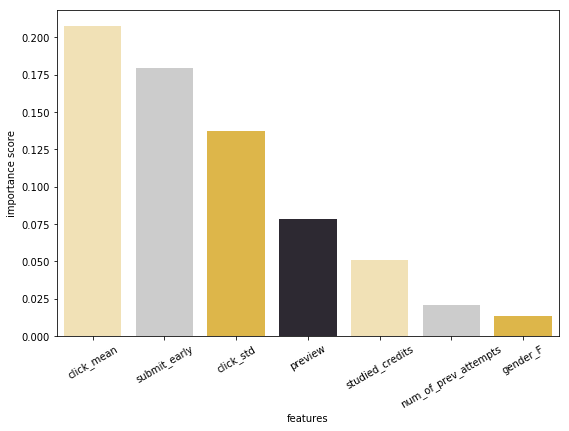

In [30]:
plt.figure(figsize=(9,6))
sns.barplot(x='features',y='importance score', data=importance_33_2[:7].sort_values(by='importance score',ascending=False)
            ,palette=["#FBE6AC","#CCCCCC","#F5C132","#2D2833"])
plt.xticks(rotation=30)

# to save: plt.savefig('33.png',transparent=True)

In [75]:
# Create confusion matrix
actuals = Y_33_test
pd.crosstab(actuals, predictions_rfc_33, rownames = ["Actual"], colnames =["Prediction"])

Prediction,Fail,Pass
Actual,,
Fail,355,774
Pass,163,2938


# Modeling with 40% of data

In [31]:
modelingdf_40 = pd.read_csv('modelingdf_40.csv')

In [32]:
modelingdf_40.isnull().sum()

gender                     0
region                     0
highest_education          0
imd_band                 998
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
click_mean                 0
submit_early            5973
preview                 4515
click_std                  0
dtype: int64

In [33]:
modelingdf_40['imd_band'] = modelingdf_40['imd_band'].fillna('NaN')
modelingdf_40['submit_early'] = modelingdf_40['submit_early'].fillna(-105)
modelingdf_40['preview'] = modelingdf_40['preview'].fillna(0)

In [34]:
modelingdf_40 = modelingdf_40[modelingdf_40['final_result']!='Withdrawn']

In [35]:
# collect categorical variables
cats=[]
for col in modelingdf_40.columns.values:
    if modelingdf_40[col].dtype == 'object':
        cats.append(col)
cats

['gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability',
 'final_result']

In [36]:
modelingdf_40_dummies = dummify_cols(modelingdf_40, cats)
modelingdf_40_dummies.head()

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,click_mean,submit_early,preview,click_std,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,imd_band_0-10%,imd_band_10-20%,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,imd_band_NaN,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y,final_result_Fail,final_result_Pass
0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,7.981481,1.0,1.0,9.007075,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
1,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,8.407407,-0.5,7.0,3.538654,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
2,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,11.759259,2.5,5.0,2.743366,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1
3,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,5.666667,-14.0,8.0,3.197831,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
4,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,12.055556,-5.0,9.0,2.860344,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1


In [37]:
feature_cols = ['num_of_prev_attempts', 'studied_credits','click_mean', 'submit_early', 'preview',
       'click_std', 'gender_F', 'gender_M', 'region_East Anglian Region',
       'region_East Midlands Region', 'region_Ireland',
       'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'imd_band_0-10%',
       'imd_band_10-20%', 'imd_band_20-30%', 'imd_band_30-40%',
       'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%',
       'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%',
       'imd_band_NaN', 'age_band_0-35', 'age_band_35-55', 'age_band_55<=',
       'disability_N', 'disability_Y']
X_40 = modelingdf_40_dummies[feature_cols]
Y_40 = modelingdf_40_dummies['final_result']
X_40_train, X_40_test, Y_40_train, Y_40_test = train_test_split(X_40, Y_40, test_size = 0.2)

In [38]:
dt_40 = tree.DecisionTreeClassifier() # 디시전트리 모델을 만들어 주고 (parameter는 훨씬 많아요!, 자세한건 shift+tab)
dt_40.fit(X_40_train[feature_cols], Y_40_train) # 예측하고
predictions_dt_40 = dt_40.predict(X_40_test[feature_cols]) # 예상한 값을 볼 수 있게 predictions라는 변수명으로 저장해줍니다

In [39]:
# accuracy
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_40_test, predictions_dt_40) * 100))

Accuracy: 71.94%


In [40]:
# RandomForest
rfc_40 = RandomForestClassifier(criterion='gini',n_estimators=100)
rfc_40.fit(X_40_train[feature_cols], Y_40_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
predictions_rfc_40 = rfc_40.predict(X_40_test[feature_cols])
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_40_test, predictions_rfc_40) * 100))

Accuracy: 81.87%


In [42]:
importance_40 = pd.DataFrame(rfc_40.feature_importances_,index = X_40_train[feature_cols].columns, columns = ["importance"])

In [43]:
importance_40_2 = importance_40.reset_index()
importance_40_2.columns = ['features','importance score']

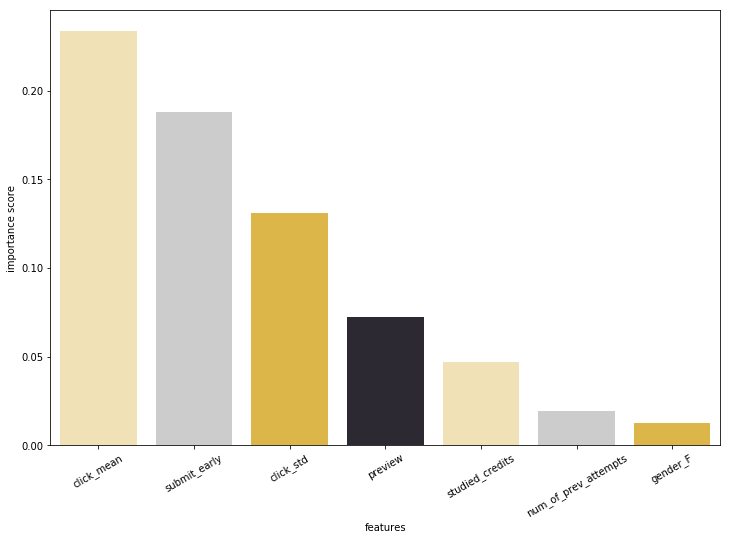

In [44]:
plt.figure(figsize=(12,8))
sns.barplot(x='features',y='importance score', data=importance_40_2[:7].sort_values(by='importance score', ascending=False),palette=["#FBE6AC","#CCCCCC","#F5C132","#2D2833"])
plt.xticks(rotation=30)

# to save : plt.savefig('40.png',transparent=True)

In [74]:
actuals = Y_40_test
pd.crosstab(actuals, predictions_rfc_40, rownames = ["Actual"], colnames =["Prediction"])

Prediction,Fail,Pass
Actual,,
Fail,482,630
Pass,137,2981


# Modeling with 50% of data

In [45]:
modelingdf_50 = pd.read_csv('modelingdf_50.csv')

In [46]:
modelingdf_50.isnull().sum()

gender                     0
region                     0
highest_education          0
imd_band                 998
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
click_mean                 0
submit_early            7765
preview                 4515
click_std                  0
dtype: int64

In [47]:
modelingdf_50['imd_band'] = modelingdf_50['imd_band'].fillna('NaN')
modelingdf_50['submit_early'] = modelingdf_50['submit_early'].fillna(-105)
modelingdf_50['preview'] = modelingdf_50['preview'].fillna(0)

In [48]:
modelingdf_50 = modelingdf_50[modelingdf_50['final_result']!='Withdrawn']

In [49]:
# collect categorical variables
cats=[]
for col in modelingdf_50.columns.values:
    if modelingdf_50[col].dtype == 'object':
        cats.append(col)
cats

['gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability',
 'final_result']

In [50]:
modelingdf_50_dummies = dummify_cols(modelingdf_50,cats[:6])
modelingdf_50_dummies.head()

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,click_mean,submit_early,preview,click_std,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,imd_band_0-10%,imd_band_10-20%,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,imd_band_NaN,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,4.529915,1.333333,1.0,7.507391,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
1,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,5.820513,-1.666667,7.0,3.249481,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,9.076923,2.333333,5.0,2.755580,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,3.863248,-11.666667,8.0,3.185682,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,8.495726,-3.333333,9.0,2.802059,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0


In [51]:
feature_cols = ['num_of_prev_attempts', 'studied_credits','click_mean', 'submit_early', 'preview',
       'click_std', 'gender_F', 'gender_M', 'region_East Anglian Region',
       'region_East Midlands Region', 'region_Ireland',
       'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'imd_band_0-10%',
       'imd_band_10-20%', 'imd_band_20-30%', 'imd_band_30-40%',
       'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%',
       'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%',
       'imd_band_NaN', 'age_band_0-35', 'age_band_35-55', 'age_band_55<=',
       'disability_N', 'disability_Y']
X_50 = modelingdf_50_dummies[feature_cols]
Y_50 = modelingdf_50_dummies['final_result']
X_50_train, X_50_test, Y_50_train, Y_50_test = train_test_split(X_50, Y_50, test_size = 0.2)

In [54]:
dt_50 = tree.DecisionTreeClassifier()
dt_50.fit(X_50_train[feature_cols], Y_50_train) 
predictions_dt_50 = dt_50.predict(X_50_test[feature_cols])

In [55]:
# accuracy
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_50_test, predictions_dt_50) * 100))

Accuracy: 72.08%


In [56]:
# RandomForest
rfc_50 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_50.fit(X_50_train[feature_cols], Y_50_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
predictions_rfc_50=rfc_50.predict(X_50_test[feature_cols])
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_50_test, predictions_rfc_50) * 100))

Accuracy: 81.25%


In [58]:
rfc_50_choose = RandomForestClassifier(criterion='gini',max_depth=5, max_leaf_nodes=None,
                             min_samples_leaf=3, n_estimators=100, n_jobs=1,)
rfc_50_choose.fit(X_50_train[feature_cols], Y_50_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [69]:
predictions_rfc_50_choose=rfc_50_choose.predict(X_50_test[feature_cols])
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_50_test, predictions_rfc_50) * 100))

Accuracy: 81.25%


In [70]:
importance_50 = pd.DataFrame(rfc_50.feature_importances_,index = X_50_train[feature_cols].columns, columns = ["importance"])

In [71]:
importance_50_2 = importance_50.reset_index()
importance_50_2.columns = ['features','importance score']

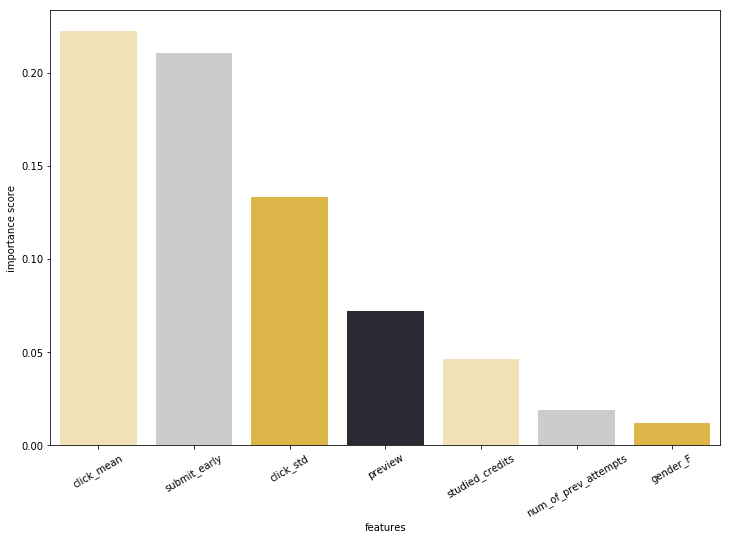

In [62]:
plt.figure(figsize=(12,8))
sns.barplot(x='features',y='importance score', data=importance_50_2[:7].sort_values(by='importance score', ascending=False),palette=["#FBE6AC","#CCCCCC","#F5C132","#2D2833"])
plt.xticks(rotation=30)

# to save: plt.savefig('50.png',transparent=True)

In [73]:
# Create confusion matrix
actuals = Y_50_test
pd.crosstab(actuals, predictions_rfc_50, rownames = ["Actual"], colnames =["Prediction"] )

Prediction,Fail,Pass
Actual,,
Fail,582,570
Pass,223,2855


--------------------

In [76]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

In [81]:
gnb = GaussianNB()
gnb.fit(X_33_train[feature_cols], Y_33_train)
predictions_gnb_33 = gnb.predict(X_33_test[feature_cols])

In [82]:
# accuracy
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_33_test, predictions_gnb_33) * 100))

Accuracy: 65.37%


In [83]:
# Create confusion matrix
actuals = Y_33_test
pd.crosstab(actuals, predictions_gnb_33, rownames = ["Actual"], colnames =["Prediction"] )

Prediction,Fail,Pass
Actual,,
Fail,635,494
Pass,971,2130


In [84]:
gnb.fit(X_40_train[feature_cols], Y_40_train)
predictions_gnb_40 = gnb.predict(X_40_test[feature_cols])

print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_40_test, predictions_gnb_40) * 100))

Accuracy: 69.36%


In [85]:
# Create confusion matrix
actuals = Y_40_test
pd.crosstab(actuals, predictions_gnb_40, rownames = ["Actual"], colnames =["Prediction"] )

Prediction,Fail,Pass
Actual,,
Fail,729,383
Pass,913,2205


In [86]:
gnb.fit(X_50_train[feature_cols], Y_50_train)
predictions_gnb_50 = gnb.predict(X_50_test[feature_cols])

In [87]:
# accuracy
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_50_test, predictions_gnb_50) * 100))

Accuracy: 70.28%


In [88]:
# Create confusion matrix
actuals = Y_50_test
pd.crosstab(actuals, predictions_gnb_50, rownames = ["Actual"], colnames =["Prediction"] )

Prediction,Fail,Pass
Actual,,
Fail,808,344
Pass,913,2165


---------

In [89]:
!pip install mlxtend

In [102]:
# Class count
count_class_0, count_class_1 = modelingdf_33_dummies.final_result.value_counts()

# Divide by class
df_class_0 = modelingdf_33_dummies[modelingdf_33_dummies['final_result'] == 'Pass']
df_class_1 = modelingdf_33_dummies[modelingdf_33_dummies['final_result'] == 'Fail']

# Making under sample dataset
df_class_0_under1 = df_class_0.sample(count_class_1)
df_test_under1 = pd.concat([df_class_0_under1, df_class_1], axis=0)

df_class_0_under2 = df_class_0.sample(count_class_1)
df_test_under2 = pd.concat([df_class_0_under2, df_class_1], axis=0)

df_class_0_under3 = df_class_0.sample(count_class_1)
df_test_under3 = pd.concat([df_class_0_under3, df_class_1], axis=0)

df_class_0_under4 = df_class_0.sample(count_class_1)
df_test_under4 = pd.concat([df_class_0_under4, df_class_1], axis=0)

df_class_0_under5 = df_class_0.sample(count_class_1)
df_test_under5 = pd.concat([df_class_0_under5, df_class_1], axis=0)

df_class_0_under6 = df_class_0.sample(count_class_1)
df_test_under6 = pd.concat([df_class_0_under6, df_class_1], axis=0)

df_class_0_under7 = df_class_0.sample(count_class_1)
df_test_under7 = pd.concat([df_class_0_under7, df_class_1], axis=0)

df_class_0_under8 = df_class_0.sample(count_class_1)
df_test_under8 = pd.concat([df_class_0_under8, df_class_1], axis=0)

df_class_0_under9 = df_class_0.sample(count_class_1)
df_test_under9 = pd.concat([df_class_0_under9, df_class_1], axis=0)

df_class_0_under10 = df_class_0.sample(count_class_1)
df_test_under10 = pd.concat([df_class_0_under10, df_class_1], axis=0)

df_class_0_under11 = df_class_0.sample(count_class_1)
df_test_under11 = pd.concat([df_class_0_under11, df_class_1], axis=0)

df_class_0_under12 = df_class_0.sample(count_class_1)
df_test_under12 = pd.concat([df_class_0_under12, df_class_1], axis=0)

df_class_0_under13 = df_class_0.sample(count_class_1)
df_test_under13 = pd.concat([df_class_0_under13, df_class_1], axis=0)

df_class_0_under14 = df_class_0.sample(count_class_1)
df_test_under14 = pd.concat([df_class_0_under14, df_class_1], axis=0)

df_class_0_under15 = df_class_0.sample(count_class_1)
df_test_under15 = pd.concat([df_class_0_under15, df_class_1], axis=0)

df_class_0_under16 = df_class_0.sample(count_class_1)
df_test_under16 = pd.concat([df_class_0_under16, df_class_1], axis=0)

df_class_0_under17 = df_class_0.sample(count_class_1)
df_test_under17 = pd.concat([df_class_0_under17, df_class_1], axis=0)

df_class_0_under18 = df_class_0.sample(count_class_1)
df_test_under18 = pd.concat([df_class_0_under18, df_class_1], axis=0)

df_class_0_under19 = df_class_0.sample(count_class_1)
df_test_under19 = pd.concat([df_class_0_under19, df_class_1], axis=0)

df_class_0_under20 = df_class_0.sample(count_class_1)
df_test_under20 = pd.concat([df_class_0_under20, df_class_1], axis=0)

In [ ]:
feature_cols = ['num_of_prev_attempts', 'studied_credits','click_mean', 'submit_early', 'preview',
       'click_std', 'gender_F', 'gender_M', 'region_East Anglian Region',
       'region_East Midlands Region', 'region_Ireland',
       'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'imd_band_0-10%',
       'imd_band_10-20%', 'imd_band_20-30%', 'imd_band_30-40%',
       'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%',
       'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%',
       'imd_band_NaN', 'age_band_0-35', 'age_band_35-55', 'age_band_55<=',
       'disability_N', 'disability_Y']

In [106]:
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection

# Fit random forest1
X_33_under1 = df_test_under1[feature_cols]
Y_33_under1 = df_test_under1['final_result']
X_33_under1_train, X_33_under1_test, Y_33_under1_train, Y_33_under1_test = train_test_split(X_33_under1, Y_33_under1, test_size = 0.2)

rfc_33_under1 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under1.fit(X_33_under1_train, Y_33_under1_train)

# Fit random forest2
X_33_under2 = df_test_under2[feature_cols]
Y_33_under2 = df_test_under2['final_result']
X_33_under2_train, X_33_under2_test, Y_33_under2_train, Y_33_under2_test = train_test_split(X_33_under2, Y_33_under2, test_size = 0.2)

rfc_33_under2 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under2.fit(X_33_under2_train[feature_cols], Y_33_under2_train)

# Fit random forest3
X_33_under3 = df_test_under3[feature_cols]
Y_33_under3 = df_test_under3['final_result']
X_33_under3_train, X_33_under3_test, Y_33_under3_train, Y_33_under3_test = train_test_split(X_33_under3, Y_33_under3, test_size = 0.2)

rfc_33_under3 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under3.fit(X_33_under3_train[feature_cols], Y_33_under3_train)

# Fit random forest4
X_33_under4 = df_test_under4[feature_cols]
Y_33_under4 = df_test_under4['final_result']
X_33_under4_train, X_33_under4_test, Y_33_under4_train, Y_33_under4_test = train_test_split(X_33_under4, Y_33_under4, test_size = 0.2)

rfc_33_under4 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under4.fit(X_33_under4_train[feature_cols], Y_33_under4_train)

# Fit random forest5
X_33_under5 = df_test_under5[feature_cols]
Y_33_under5 = df_test_under5['final_result']
X_33_under5_train, X_33_under5_test, Y_33_under5_train, Y_33_under5_test = train_test_split(X_33_under5, Y_33_under5, test_size = 0.2)

rfc_33_under5 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under5.fit(X_33_under5_train[feature_cols], Y_33_under5_train)

# Fit random forest6
X_33_under6 = df_test_under6[feature_cols]
Y_33_under6 = df_test_under6['final_result']
X_33_under6_train, X_33_under6_test, Y_33_under6_train, Y_33_under6_test = train_test_split(X_33_under6, Y_33_under6, test_size = 0.2)

rfc_33_under6 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under6.fit(X_33_under6_train[feature_cols], Y_33_under6_train)

# Fit random forest7
X_33_under7 = df_test_under7[feature_cols]
Y_33_under7 = df_test_under7['final_result']
X_33_under7_train, X_33_under7_test, Y_33_under7_train, Y_33_under7_test = train_test_split(X_33_under7, Y_33_under7, test_size = 0.2)

rfc_33_under7 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under7.fit(X_33_under7_train[feature_cols], Y_33_under7_train)

# Fit random forest8
X_33_under8 = df_test_under8[feature_cols]
Y_33_under8 = df_test_under8['final_result']
X_33_under8_train, X_33_under8_test, Y_33_under8_train, Y_33_under8_test = train_test_split(X_33_under8, Y_33_under8, test_size = 0.2)

rfc_33_under8 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under8.fit(X_33_under8_train[feature_cols], Y_33_under8_train)

# Fit random forest9
X_33_under9 = df_test_under9[feature_cols]
Y_33_under9 = df_test_under9['final_result']
X_33_under9_train, X_33_under9_test, Y_33_under9_train, Y_33_under9_test = train_test_split(X_33_under9, Y_33_under9, test_size = 0.2)

rfc_33_under9 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under9.fit(X_33_under9_train[feature_cols], Y_33_under9_train)

# Fit random forest10
X_33_under10 = df_test_under10[feature_cols]
Y_33_under10 = df_test_under10['final_result']
X_33_under10_train, X_33_under10_test, Y_33_under10_train, Y_33_under10_test = train_test_split(X_33_under10, Y_33_under10, test_size = 0.2)

rfc_33_under10 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under10.fit(X_33_under10_train[feature_cols], Y_33_under10_train)

# Fit random forest11
X_33_under11 = df_test_under11[feature_cols]
Y_33_under11 = df_test_under11['final_result']
X_33_under11_train, X_33_under11_test, Y_33_under11_train, Y_33_under11_test = train_test_split(X_33_under11, Y_33_under11, test_size = 0.2)

rfc_33_under11 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under11.fit(X_33_under11_train[feature_cols], Y_33_under11_train)

# Fit random forest12
X_33_under12 = df_test_under12[feature_cols]
Y_33_under12 = df_test_under12['final_result']
X_33_under12_train, X_33_under12_test, Y_33_under12_train, Y_33_under12_test = train_test_split(X_33_under12, Y_33_under12, test_size = 0.2)

rfc_33_under12 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under12.fit(X_33_under12_train[feature_cols], Y_33_under12_train)

# Fit random forest13
X_33_under13 = df_test_under13[feature_cols]
Y_33_under13 = df_test_under13['final_result']
X_33_under13_train, X_33_under13_test, Y_33_under13_train, Y_33_under13_test = train_test_split(X_33_under13, Y_33_under13, test_size = 0.2)

rfc_33_under13 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under13.fit(X_33_under13_train[feature_cols], Y_33_under13_train)

# Fit random forest14
X_33_under14 = df_test_under14[feature_cols]
Y_33_under14 = df_test_under14['final_result']
X_33_under14_train, X_33_under14_test, Y_33_under14_train, Y_33_under14_test = train_test_split(X_33_under14, Y_33_under14, test_size = 0.2)

rfc_33_under14 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under14.fit(X_33_under14_train[feature_cols], Y_33_under14_train)

# Fit random forest15
X_33_under15 = df_test_under15[feature_cols]
Y_33_under15 = df_test_under15['final_result']
X_33_under15_train, X_33_under15_test, Y_33_under15_train, Y_33_under15_test = train_test_split(X_33_under15, Y_33_under15, test_size = 0.2)

rfc_33_under15 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under15.fit(X_33_under15_train[feature_cols], Y_33_under15_train)

# Fit random forest16
X_33_under16 = df_test_under16[feature_cols]
Y_33_under16 = df_test_under16['final_result']
X_33_under16_train, X_33_under16_test, Y_33_under16_train, Y_33_under16_test = train_test_split(X_33_under16, Y_33_under16, test_size = 0.2)

rfc_33_under16 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under16.fit(X_33_under16_train[feature_cols], Y_33_under16_train)

# Fit random forest17
X_33_under17 = df_test_under17[feature_cols]
Y_33_under17 = df_test_under17['final_result']
X_33_under17_train, X_33_under17_test, Y_33_under17_train, Y_33_under17_test = train_test_split(X_33_under17, Y_33_under17, test_size = 0.2)

rfc_33_under17 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under17.fit(X_33_under17_train[feature_cols], Y_33_under17_train)

# Fit random forest18
X_33_under18 = df_test_under18[feature_cols]
Y_33_under18 = df_test_under18['final_result']
X_33_under18_train, X_33_under18_test, Y_33_under18_train, Y_33_under18_test = train_test_split(X_33_under18, Y_33_under18, test_size = 0.2)

rfc_33_under18 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under18.fit(X_33_under18_train[feature_cols], Y_33_under18_train)

# Fit random forest19
X_33_under19 = df_test_under19[feature_cols]
Y_33_under19 = df_test_under19['final_result']
X_33_under19_train, X_33_under19_test, Y_33_under19_train, Y_33_under19_test = train_test_split(X_33_under19, Y_33_under19, test_size = 0.2)

rfc_33_under19 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under19.fit(X_33_under19_train[feature_cols], Y_33_under19_train)

# Fit random forest20
X_33_under20 = df_test_under20[feature_cols]
Y_33_under20 = df_test_under20['final_result']
X_33_under20_train, X_33_under20_test, Y_33_under20_train, Y_33_under20_test = train_test_split(X_33_under20, Y_33_under20, test_size = 0.2)

rfc_33_under20 = RandomForestClassifier(criterion='gini', n_estimators=100)
rfc_33_under20.fit(X_33_under20_train[feature_cols], Y_33_under20_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [108]:
test=[]
randomforest=[]
for i in range(100):
    tmp = df_class_0.sample(count_class_1)
    tmpp = pd.concat([tmp, df_class_1], axis=0)
    test.append(tmpp)

for i in range(100):
    x = test[i][feature_cols]
    y = test[i]['final_result']
    xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2)
    
    rf = RandomForestClassifier(criterion='gini', n_estimators=100)
    rf.fit(xtrain[feature_cols], ytrain)
    randomforest.append(rf)
    
stackedrf = StackingClassifier(classifiers=randomforest[1:], meta_classifier=randomforest[0])

# Stack 20 random forest
stackedrf = StackingClassifier(classifiers=[rfc_33_under2,rfc_33_under3,rfc_33_under4,rfc_33_under5,rfc_33_under6,
                                            rfc_33_under7,rfc_33_under8,rfc_33_under9,rfc_33_under10,
                                            rfc_33_under11,rfc_33_under12,rfc_33_under13,rfc_33_under14,rfc_33_under15,
                                            rfc_33_under16,rfc_33_under17,rfc_33_under18,rfc_33_under19,rfc_33_under20], 
                               meta_classifier=rfc_33_under1)


modelingdf_33_dummies['final_result'] = modelingdf_33_dummies['final_result'].map(lambda x: 1 if x=='Pass' else 0)

X_33 = modelingdf_33_dummies[feature_cols]
Y_33 = modelingdf_33_dummies['final_result']
X_33_train, X_33_test, Y_33_train, Y_33_test = train_test_split(X_33, Y_33, test_size = 0.2)

stackedrf.fit(X_33_train, Y_33_train)
predictions_stackedrf=stackedrf.predict(X_33_test)
print('Accuracy: {:.2f}%'.format(sklearn.metrics.accuracy_score(Y_33_test, predictions_stackedrf) * 100))

# Create confusion matrix
actuals_total = Y_33_test
pd.crosstab(actuals_total, predictions_stackedrf, rownames = ["Actual"], colnames =["Prediction"] )

Accuracy: 79.39%


Prediction,0,1
Actual,,
0,406,738
1,134,2952
